# Sheet 11
## Ex 1
A

## Ex 2
(a) 
Show that for a general equivariant function $h(x)$ that the output has the same symmetries as the input, e.g.
$$\rho(g)x = x \implies \rho'(g) h(x) = h(x).$$

Proof: The defining property of equivariance is here $\rho(g)h(x) = h(\rho'(x))$. Thus
$$h(x) = h(\rho(g)x) = \rho'(g)h(x) .$$


(b)
We consider an $SO(3)$-equivariant GNN $f$ taking as input a set $P$ of $p$ vectors $x_i \in \mathbb{R}^3$. It is further invariant w.r.t. permutations of the input  by means of message passing (cf. Ch. 4.2.2 https://cs.mcgill.ca/~wlh/comp766/files/chapter4_draft_mar29.pdf). The GNN maps the set of vectors to an $3$-vector,
$$f: \mathbb{R}^{3\times p} \rightarrow \mathbb{R}^3.$$
Assume that the input $P$ is sampled evenly from an ellipsoid and that the output $f(P)$ ought to transform like a vector. Argue that the output can only be the zero vector,
$$f(P') = Rf(P) \implies f(P) = 0.$$


Argument: Consider the discrete group under matrix multiplication with elements that have representations of the kind $Diag(\pm 1,\pm 1,\pm 1) \in \mathbb{R}^3 $ in the principal basis of the ellipsoid. Since the point clouds are sampled evenly from the ellispoid, they are invariant under this discrete symmetry group up to noise. By (a), $f$ must preserve the discrete symmetry in the output, implying
$$f(P) = f(-P) = -f(P).$$ 
and hence $f(P) = 0 ~\forall ~P.$

(c)

In [1]:
from e3nn.o3 import Irrep, Irreps
from e3nn import o3
import matplotlib.pyplot as plt
import torch

1.

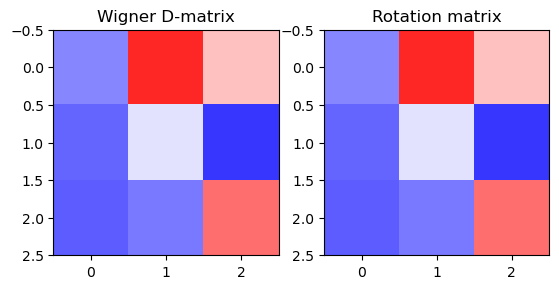

In [2]:
# get random element of O#
rot = o3.rand_matrix().to(dtype=torch.float64)
irreps = Irreps("1e")
# calculate the Wigner D-matrix

D = irreps.D_from_matrix(rot)

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(D, cmap='bwr', vmin=-1, vmax=1)
ax1.set_title("Wigner D-matrix")
ax2.imshow(rot, cmap='bwr', vmin=-1, vmax=1)
ax2.set_title("Rotation matrix");

2.

In [3]:
for l in [2,3,4]:
    irrep = Irrep(str(l)+"e") # e = even = no inversion = proper SO3 with determinant +1
    expected_matrix_dimension = (2*l + 1, 2*l + 1)
    actual_matrix_dimension = tuple(irrep.D_from_matrix(rot).shape)
    print("Expected",expected_matrix_dimension, "Found", actual_matrix_dimension)

Expected (5, 5) Found (5, 5)
Expected (7, 7) Found (7, 7)
Expected (9, 9) Found (9, 9)


Checks out. 

3.

In [4]:
x = random_vec = torch.randn(3).to(dtype=torch.float64)
for l in [1,2,3,4]:
    # 1. Rotate before calculating SH
    y = rotated_input = rot @ random_vec
    # 2. Calculate SH of rotated input
    u = o3.spherical_harmonics(l, y, normalize=True)

    # 3. Calculate SH of input
    _v = o3.spherical_harmonics(l, x, normalize=True)
    # 4. Rotate after calculating SH
    WDmat = Irreps(str(l)+"e").D_from_matrix(rot)
    v = WDmat @ _v

    # 5. Compare
    print(f"l={l}, deviation = ", torch.norm(u-v))


l=1, deviation =  tensor(1.4984e-07, dtype=torch.float64)
l=2, deviation =  tensor(3.4881e-07, dtype=torch.float64)
l=3, deviation =  tensor(6.3489e-07, dtype=torch.float64)
l=4, deviation =  tensor(9.9959e-07, dtype=torch.float64)


Commutes up to floating point precision.

4.

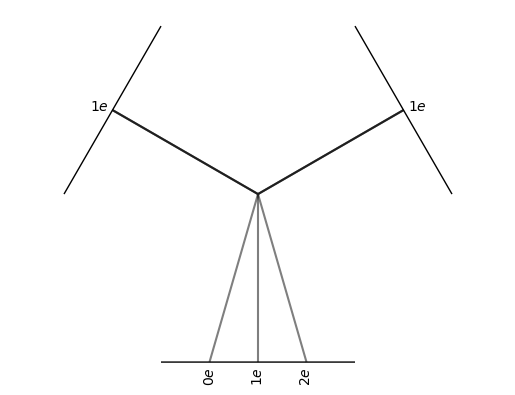

In [5]:
irrep_a = Irreps("1e")
irrep_b = Irreps("1e")
product = o3.FullTensorProduct(irrep_a, irrep_b)
product.visualize();

Indeed, the tensor product has three summands, where the number is $\ell$. Applying $2\ell +1$ yields the excpected decomposition 
$$2\cdot 0 + 1 \oplus 2\cdot 1 +1 \oplus 2\cdot 2 + 1 = 1 + 3 + 5.$$

5. We calculate $R(v\otimes u)R^T$ and compare it to $(Rv) \otimes (Ru)$

In [6]:
rot = o3.rand_matrix().to(dtype=torch.float64)

u = torch.tensor([1,2,3], dtype=torch.float64)
v = torch.tensor([4,5,6], dtype=torch.float64)

product = torch.outer(u, v)
rotated_product = torch.matmul(torch.matmul(rot, product), rot.T)

product2 = torch.outer(torch.matmul(rot, u), torch.matmul(rot, v))

rotated_product - product2

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)

6. Full Tensor Product

(<Figure size 640x480 with 1 Axes>, <Axes: >)

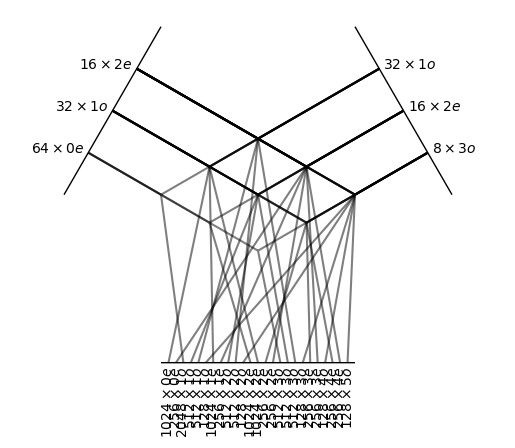

In [7]:
in1 = Irreps("64x0e+32x1o+16x2e")
in2 = Irreps("32x1o+16x2e+8x3o")

product = o3.FullTensorProduct(in1, in2)
product.visualize()

In [8]:
calculated_output_irreps = {l:0 for l in range(0,6)}
for multiplicity, l1 in ((16,2), (32, 1), (64, 0)):
    for m2, l2 in ((32, 1), (16,2), (8,3)):
        for L in range(abs(l1-l2), l1+l2+1):
            calculated_output_irreps[L] += multiplicity * m2 


true_output_irreps = dict()
for L in range(0,6):
    true_output_irreps[L] = product.irreps_out.count(f"{L}e") + product.irreps_out.count(f"{L}o")

In [9]:
calculated_output_irreps, true_output_irreps

({0: 1280, 1: 4480, 2: 3712, 3: 2176, 4: 640, 5: 128},
 {0: 1280, 1: 4480, 2: 3712, 3: 2176, 4: 640, 5: 128})

## 3 Electron densities
(a)
There are multiple ways of addressing this problem. For instance, one might introduce a regularization term that penalizes negative densities somehow, for instance by integrating the density on the grid where it is negative. Another, more scalable way, would be to check if its possible to make some of the components of $p_\mu$ dependent parameters such that positive densities everywhere are guaranteed, but this loses degrees of freedom. Finally, one could use $$\hat n(x) =\max(0, n(x))$$ to ensure positive densities.

(b)
By setting $$n(x) = (\sum_\mu  p_\mu \omega_\mu)^2,$$
the basis functions lose expressivity because the square in the exponent essentially turns linear regions into quadratic ones. Think of something like $$\omega \propto |x| \rightarrow \omega^2 \propto |x|^2 $$
Since the discontinuity conveniently models sharp transitions, thus squaring the orbital loses expressivity at the origin. 